<a href="https://colab.research.google.com/github/2pterons/multicampus/blob/main/1_20211005_KoGPT2_idiom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **⦁ GPT** 구조

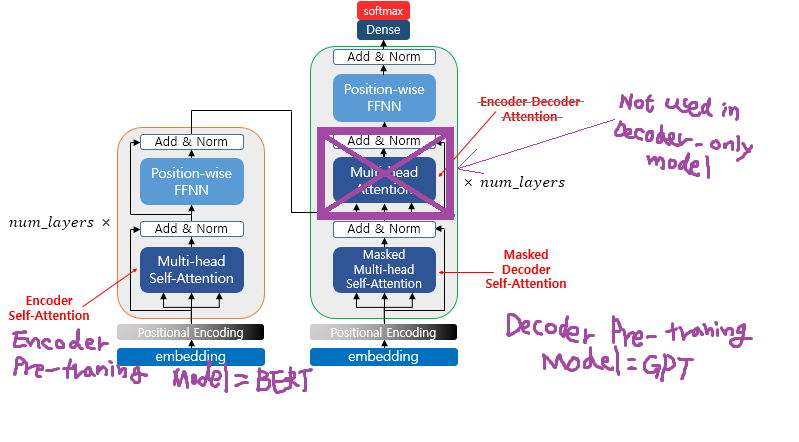

<br/><br/>

# **KoGPT2를 이용한 감성분석**
<br/>


### 1. 라이브러리 설치 및 임포트

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


In [ ]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

     |████████████████████████████████| 344 kB 5.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595735 sha256=4c2e181a3fb70fc278bdd3362d3e01d17baed9b3cce63515612a9a5e138af0e2
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 52.5 MB/s 
     |████████████████████████████████| 636 kB 37.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 109 kB 50.6 MB/s 
     |████████████████████████████████| 546 kB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


<br/><br/>
### 2. pickle을 이용해 final_idiom_dataset_for_ko.pkl 읽어오기 및 변수에 담기

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
"""
final_idiom_dataset_for_ko.pkl
 - 관용구 포함 문장(1): 3,376개 ( KISS data )
 - 관용구 미포함 문장(0): 3,376개 ( AI Hub에서 위 KISS data 제외, 중복 제거한 뒤 3,376개를 random sampling )
"""
import pickle
#with open('./final_idiom_dataset_for_ko.pkl', 'rb') as f:
with open('./1/train_11710.pkl','rb') as f:
  text = pickle.load(f)

In [ ]:
text.head()

,ko,Label
0,그 노력이 말뿐인지 아닌지 두고 봐야 한다.,1
1,“가수가 연애한다고 퇴출까지 하는 것은 너무하다”는 부정적인 반응이 일각에서 나오자...,0
2,남북 경제협력을 염두에 둔 것이라지만 해외는 안 되는데 북한은 된다는 것은 앞뒤가 ...,1
3,더 이상 고발자들이 힘겹게 본인의 이야기를 꺼내지 않을 수 있도록 정부가 먼저 전수...,1
4,경찰은 문제의 앱이 ‘폴-안티스파이’인 것처럼 위장해 기기 정보와 개인 정보를 빼가...,0


In [ ]:
data = text['ko']
data.head()

0                             그 노력이 말뿐인지 아닌지 두고 봐야 한다.
1    “가수가 연애한다고 퇴출까지 하는 것은 너무하다”는 부정적인 반응이 일각에서 나오자...
2    남북 경제협력을 염두에 둔 것이라지만 해외는 안 되는데 북한은 된다는 것은 앞뒤가 ...
3    더 이상 고발자들이 힘겹게 본인의 이야기를 꺼내지 않을 수 있도록 정부가 먼저 전수...
4    경찰은 문제의 앱이 ‘폴-안티스파이’인 것처럼 위장해 기기 정보와 개인 정보를 빼가...
Name: ko, dtype: object

In [ ]:
target = text['Label']
target.head()

0    1
1    0
2    1
3    1
4    0
Name: Label, dtype: int64

<br/><br/>
### pre-training 데이터


In [ ]:
dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [ ]:
MAX_LEN = 60
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [ ]:
x_train, y_train = build_data(dx_train, dy_train)
x_test, y_test = build_data(dx_test, dy_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((9368, 62), (9368, 1), (2342, 62), (2342, 1))

In [ ]:
x_test[0]


array([    0,   233,   131, 26474,   169,  1055, 35562,  1803,  3282,
        6163,   147,  3020,  7657, 47438,  9740,  9102,  3834,   908,
        4509,   350, 47440,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     1])

In [ ]:
len(x_test[0])

62

In [ ]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [ ]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]


'▁전세'

In [ ]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

['<s>', '▁매', '▁주', '▁성당', '▁미', '사에', '▁나가지', '▁않는다', '해도', '▁그들의', '▁일', '상은', '▁가톨릭', '이', '▁몸에', '▁밴', '▁종교', '인이', '▁확실', '하다', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [ ]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = True
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)


In [ ]:
# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [ ]:
# Downstream task : idiom classifier
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-5))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 124,292,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=1)

Epoch 1/3
9368/9368 [==============================] - 344s 36ms/step - loss: 0.3360 - val_loss: 0.1879
Epoch 2/3
9368/9368 [==============================] - 332s 35ms/step - loss: 0.1105 - val_loss: 0.1645
Epoch 3/3
9368/9368 [==============================] - 334s 36ms/step - loss: 0.0590 - val_loss: 0.1441


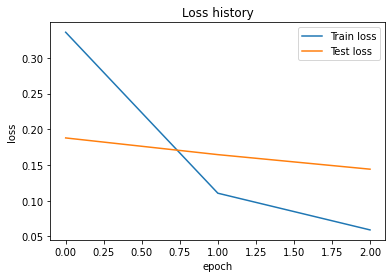

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
gpt_model.trainable = False
gpt_model.summary()

Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-6))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:
x_train

array([[    0, 28601,  2993, ...,     3,     3,     1],
       [    0,  3868, 47690, ...,     3,     3,     1],
       [    0,  7112,   162, ...,     3,     3,     1],
       ...,
       [    0,   783,  4447, ..., 24155, 47440,     1],
       [    0,   167, 47531, ...,     3,     3,     1],
       [    0,  7472,  2805, ...,     3,     3,     1]])

In [ ]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
147/147 [==============================] - 51s 254ms/step - loss: 0.0174 - val_loss: 0.1482
Epoch 2/3
147/147 [==============================] - 34s 233ms/step - loss: 0.0158 - val_loss: 0.1516
Epoch 3/3
147/147 [==============================] - 34s 233ms/step - loss: 0.0173 - val_loss: 0.1537


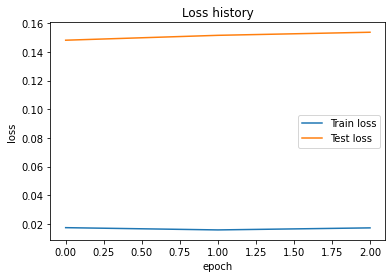

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [ ]:
"""from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
# 정확도
print("accuracy:", accuracy_score(y_test, y_pred))

# 정밀도
print("precision:", precision_score(y_test, y_pred))

# 재현율
print("recall:", recall_score(y_test, y_pred))

# f1-score
print("F1-Score:", f1_score(y_test, y_pred))"""

'from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix\n# 오차행렬\n# 정확도\nprint("accuracy:", accuracy_score(y_test, y_pred))\n\n# 정밀도\nprint("precision:", precision_score(y_test, y_pred))\n\n# 재현율\nprint("recall:", recall_score(y_test, y_pred))\n\n# f1-score\nprint("F1-Score:", f1_score(y_test, y_pred))'

In [ ]:
# 새로운 문장으로 테스트
#new_test = pd.read_csv('./idiom_dataset(18808).csv')
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data
import pickle
with open('./1/test_3000.pkl', 'rb') as f:
  new_test = pickle.load(f)
new_test

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


,ko,Label
0,더 큰 문제는 자영업자들이 상황을 타개하기 위해 부채를 확대하고 있어 잠재부실에 대...,0
1,팝콘이랑 콜라 쓰레기는 버리고 오지 왜 들고 다니니?,0
2,"삼성전자의 가시적인 목표는 파운드리 분야에서 대만 TSMC를 따라잡고, AP와 모뎀...",1
3,그런 만큼 이 시점에 우리 정부가 적극 개입해 북-미 사이에 다리를 놓는 것도 필요...,1
4,김 후보자는 개성공단 재개에 대한 원유철 자유한국당 의원의 질의에는 “지금 상황에서...,1
...,...,...
2995,마이크론은 글로벌 D램 시장에서 삼성전자와 SK하이닉스에 이어 점유율 3위 업체로 ...,1
2996,데이식스는 위촉식에서 “KYWA가 추진하는 청소년 관련 행사 및 홍보 활동에 적극 ...,0
2997,머리끝에 상판을 제외하고 그곳에는 상부구조가 없었던 거처럼 보입니다.,0
2998,색다른 매력을 지닌 배우들과 개성 있는 이야기가 한 데 어우러져 안방극장을 뜨겁게 ...,0


In [ ]:
#new_test = new_test['Label'] == 1

In [ ]:
new_test['ko'][10]
new_test = new_test.sample(frac=1).reset_index(drop=True)
new_test

,ko,Label
0,경기복지재단은 이번 콜로키움을 통해 (예비)부모들이 안심하고 공감할 수 있는 저출산...,0
1,상장 경매회사인 뉴욕소더비는 살아생전 초대받기 힘든 곳이고 설령 생전에 초대받는다 ...,1
2,이건 여자가 사용하기에는 조금 불편해.,0
3,나 너무 마음이 아파서 잠도 못 잘 거 같아요.,0
4,한동민은 이틀 연속 홈런을 터뜨렸고 4대 3으로 역전에 성공한 8회에는 강승호가 투...,1
...,...,...
2995,이를 의식한 경영진은 담화문을 통해 “물적분할에 대해 사우들이 우려하는 부분에 마침...,1
2996,실제 ‘강제징용’ 소송의 전범 기업들은 근로정신대 피해자들이 낸 소송에서 ‘소장에 ...,1
2997,"이날 환경기술을 개발한 중소기업, 연구소 등 R&D 전문기관이 최신기술을 소개하고,...",0
2998,자신도 집에서 연습할 때 입에 잘 붙지 않았는지 이미 그 대사를 연필로 슬쩍 고쳐놓...,1


In [ ]:
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)

In [ ]:
new_test_text, _ = build_data(new_test['ko'], np.zeros(len(new_test)))
answer = new_test.Label.to_list()
len(answer)
# 시험 데이터로 학습 성능을 평가한다
new_pred = model.predict(new_test_text)
new_y_pred = np.where(new_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
new_y_pred.sum()

1535

In [ ]:
new_y_pred.head()

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [ ]:
df = pd.DataFrame({'ko':new_test['ko'], 'Label':list(new_y_pred.reshape(-1,1))})

In [ ]:
for i in df[df['Label']==1]['ko']:
  print(i)

상장 경매회사인 뉴욕소더비는 살아생전 초대받기 힘든 곳이고 설령 생전에 초대받는다 해도 80, 90대의 연령이 되서 30∼40년 이상 내공과 필력이 연단된 후에 빛을 보는 특징을 가진 곳이다.
나 너무 마음이 아파서 잠도 못 잘 거 같아요.
한동민은 이틀 연속 홈런을 터뜨렸고 4대 3으로 역전에 성공한 8회에는 강승호가 투런 아치로 쐐기를 박았습니다.
경제주체들이 허리띠를 졸라매고 현금 확보에 나서고 있다는 의미다.
하루에도 몇 번씩 드나들면서 둘러봐야 직성이 풀리는 양천중학교 도서반 학생들을 만나 책 안에서 즐거움을 찾는 이야기를 들어보았다.
작년에 사망한 김알렉산드라 페트로브나 허발표(하바로브스크) 소비에트 외무위원도 발 벗고 나서 도왔는데, 기실 김씨가 없었으면 창당은 쉽지 않았을 터다.
남궁민, 권나라, 김병철, 최원영, 박은석 등 시선을 강탈하는 캐릭터 스틸컷들이 속속 공개되면서 3월 안방극장을 숨 막히는 긴장감으로 물들일 웰메이드 장르극에 대한 기대감을 수직 상승시키고 있다.
시즌 전 강력한 선발진을 바탕으로 우승 후보로 꼽혔지만 예기치 못한 선발 투수들의 잇단 부상으로 위기를 맞았던 다저스가 부상자들의 복귀로 다시 힘찬 기지개를 켠다.
내년부터 음주운전으로 2번 이상 적발되면 최대 징역 5년형을 받게 되고 음주 단속 기준도 대폭 강화돼 소주 1잔만 마시고 운전대를 잡아도 면허가 정지됩니다.
사드 배치 갈등 때처럼 우리 정부가 미국보다는 중국이나 북한에 더 기울어진 안보정책을 추진한다면 미국이 한반도에서 아예 발을 뺄 가능성도 배제할 수 없다.
그녀의 게임 실력이 보통이 아닙니다.
무엇보다 서인국(김무영 역)이 하염없이 걸으며 옥탑방에 돌아오는 길, 공허한 두 눈과 넋 나간 표정은 김무영의 절망스러운 심경을 잘 말해주었다.
먼저 비전선포식이라는 컨셉 아래 진행된 제작발표회에서는 승리 고문이 <YG전자>의 비전과 포부를 야심 차게 소개하며 포문을 열었다.
유효기간이 1년으로 최종 확정되면 한·미 양국은 숨 돌릴 틈도 없이 내년부터 적용될 11차 SMA

In [ ]:
for i in df[df['Label']==0]['ko']:
  print(i)

경기복지재단은 이번 콜로키움을 통해 (예비)부모들이 안심하고 공감할 수 있는 저출산 정책이 무엇일지 고민해보고자 한다.
이건 여자가 사용하기에는 조금 불편해.
그리스어 i는 영어로 넘어오며 자음 y와 구별이 필요할 때 j로 표기했고, 그래서 욥은 영어로 ‘Job’라 씁니다.
브리스코리아는 매장에서 기능성속옷을 구매하는 소비자에게 전문 코디가 체형별 사이즈를 측정하고, 착용하는 과정에서 소비자가 필요로 하는 건강 상담까지 진행하고 있다.
기초생활수급자 생계비와 장애연금, 주거급여 등을 합치면 한달에 120만원 정도의 소득이 있고, 여기서 월세 24만원과 관리비 9만원 정도를 내고 지낸다.
우리 카메라는 불꽃 및 화염을 포함해 모든 물체의 온도를 측정할 수 있습니다.
선체 바닥에도 외부에서 충격을 가한 흔적이 있다.
고객님께서 물건을 잘 받으셨다니 기쁩니다.
로이킴이 <수퍼스타 K>에서 우승을 차지했었을 때에는, 이미 조지타운 대학교의 입학허가서를 받은 후였다.
사용자가 트래블월렛 앱에서 원화를 환전 요청만 하면, 선불 체크카드에서 맞춤형 낮은 환율로 금액이 환전되고 해외에서 손쉽게 카드 결제까지 할 수 있다.
지금 나랑 전화 통화할 시간 있니?
많은 연구에서 협력은 경쟁보다 더 좋은 결과를 낳았으며, 그 효과도 경쟁에 비해 오래 지속했어.
이번 패션쇼에는 태국 내 최고 한류남자배우 가운데 한 명인 이준기가 메인 모델로 참석차 방문해 태국 연예뉴스를 떠들썩하게 했다.
정부나 공공기관에서 물품·용역을 구입할 때 활용하는 ‘나라장터’의 일부 물품 가격이 민간 온라인 보다 비싸다는 조사결과가 나왔다.
더불어민주당의 김태년 정책위의장은 당정협의가 끝난 뒤 “재벌개혁과 경제민주화의 법적·제도적 완성을 위해 발의된 상법 개정안 처리에도 힘을 쏟기로 했다”고 밝혔다.
12월 6일 주인도 한국문화원에서 열린 팬 미팅에서는 100여 명이 넘는 팬들이 강당을 꽉 채웠다.
배수펌프장은 장마철 집중호우 시 자연방류가 안되는 하천변 저지대 지역의 빗물을 모아 강제로 하천으로 배수하는 시

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬

# 정확도
print("accuracy:", accuracy_score(answer, new_y_pred))

# 정밀도
print("precision:", precision_score(answer, new_y_pred))

# 재현율
print("recall:", recall_score(answer, new_y_pred))

# f1-score
print("F1-Score:", f1_score(answer, new_y_pred))

accuracy: 0.955
precision: 0.9446254071661238
recall: 0.9666666666666667
F1-Score: 0.9555189456342668


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data'
model.save('/kogpt2_11710.h5')

NotImplementedError: ignored